In [1]:
#loading libraries
suppressMessages(library("DESeq2"))
suppressMessages(library(edgeR))
suppressMessages(library(lubridate))
suppressMessages(library(dplyr))
suppressMessages(library(tidyverse))
suppressMessages(library(gsheet))
suppressMessages(library(data.table))
suppressMessages(library(vegan))
suppressMessages(library(EnvStats))
suppressMessages(library(stringr))
suppressMessages(library(ineq))

Warning message:
“package ‘gsheet’ was built under R version 4.2.2”
Warning message:
“package ‘vegan’ was built under R version 4.2.2”
Warning message:
“package ‘permute’ was built under R version 4.1.3”
Warning message:
“package ‘EnvStats’ was built under R version 4.2.2”


In [2]:
setwd("/workdir/omm35/paper_urine_cfrna")
source("/workdir/omm35/paper_urine_cfrna/scripts/theme_ggplot_cfrna.R")

In [4]:
#
# platelet_gene = fread("/workdir/omm35/urine_plasma_cfRNA_comparison/metadata_key/platelet_markers.csv")
# colnames(platelet_gene)[1]="geneID"

# Loading counts from all samples

In [9]:
files = list.files(path="/workdir/omm35/paper_urine_cfrna", recursive = TRUE, pattern = "*feature_counts.tsv", full.names = TRUE)
files
counts = lapply(files,fread)
common_column <- "geneID"
counts <- Reduce(function(x, y) merge(x, y, by = common_column, all.x = TRUE), counts)
                 
                 
samples_after_QC = fread("/workdir/omm35/paper_urine_cfrna/metadata/QC_pass_samples.csv")
                 
counts = counts %>% dplyr::select(geneID,one_of(samples_after_QC$sample_id))
counts = column_to_rownames(counts, var = "geneID")                 
                 
dds <- DESeqDataSetFromMatrix(countData = counts,
colData = samples_after_QC,
design =~biofluid)
keep <- rowSums(counts(dds)) >= 10
dds <- dds[keep,]

dds <- estimateSizeFactors(dds)
                 
normalized_counts <- counts(dds, normalized=TRUE)
                 
#counts_cpm = counts %>% edgeR::cpm() %>% data.frame()
                 
            

[1] "/workdir/omm35/paper_urine_cfrna/aki_plasma/aki_cfrna_plasma_feature_counts.tsv"  
[2] "/workdir/omm35/paper_urine_cfrna/aki_urine/AKI_urine_feature_counts.tsv"          
[3] "/workdir/omm35/paper_urine_cfrna/gvhd_plasma/gvhd_hct_feature_counts.tsv"         
[4] "/workdir/omm35/paper_urine_cfrna/gvhd_urine/GVHD_feature_counts.tsv"              
[5] "/workdir/omm35/paper_urine_cfrna/healthy_plasma/healthy_plasma_feature_counts.tsv"
[6] "/workdir/omm35/paper_urine_cfrna/healthy_urine/healthy_urine_feature_counts.tsv"  
[7] "/workdir/omm35/paper_urine_cfrna/ktx_urine/KTx_feature_counts.tsv"

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


# Gini coefficient 

In [7]:
gini_results <- sapply(colnames(normalized_counts), function(sample_name) {
  gini_coefficient <- ineq::Gini(normalized_counts[, sample_name, drop = FALSE])
  return(data.frame(sample_id = sample_name, gini = gini_coefficient))
}, simplify = "data.frame")

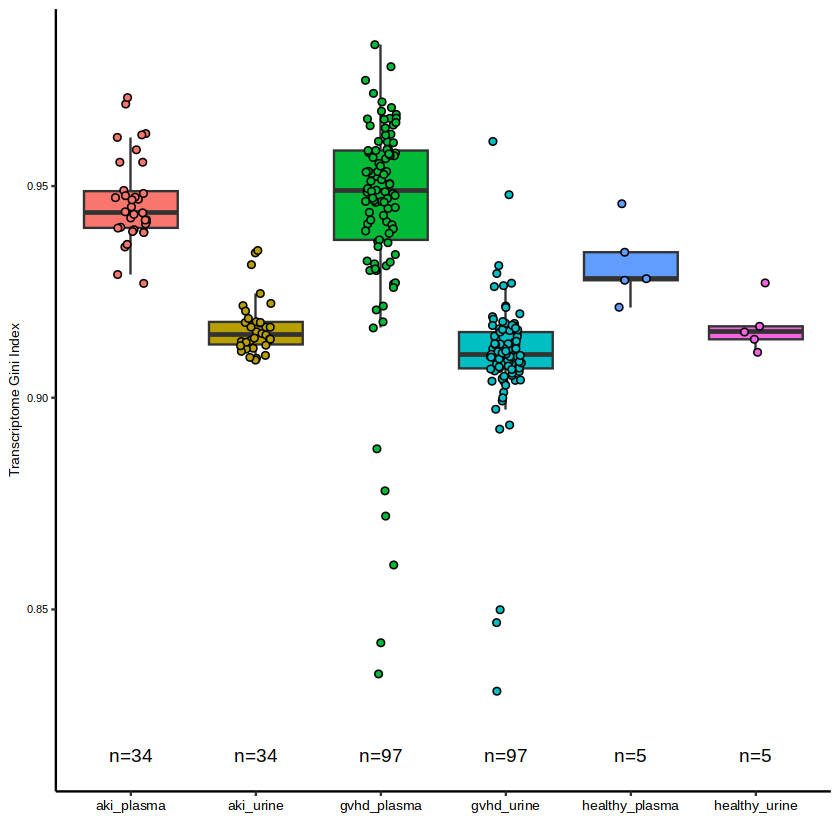

In [8]:
gini_results <- sapply(colnames(normalized_counts), function(sample_name) {
  gini_coefficient <- ineq::Gini(normalized_counts[, sample_name, drop = FALSE])
  return(data.frame(sample_id = sample_name, gini = gini_coefficient))
}, simplify = "data.frame")
gini_df <- as.data.frame(t(gini_results))
gini_df$sample_id=as.character(gini_df$sample_id)
gini_df$gini=as.numeric(gini_df$gini)
rownames(gini_df)<-NULL
gini_df <- merge(samples_after_QC, gini_df , by = 'sample_id', all.x = TRUE)


safe_colorblind_palette<-c('#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB')
gini_df %>% filter(biofluid!="ktx_urine") %>%  ggplot(aes(
    biofluid,
    gini,
    fill = biofluid,
  )) + scale_color_manual(values=safe_colorblind_palette)+
  geom_boxplot(
    outlier.shape = NA,
    aes(group = biofluid),
  ) + 
  geom_jitter(width = 0.125, show.legend = F, shape = 21) +
  ylab('Transcriptome Gini Index') + xlab('')  + 
  theme_classic()+ theme(
axis.title.x = element_text(size = 8,family = "Helvetica", color="black"),
    axis.text.x = element_text(size = 8,family = "Helvetica", color="black"),
    axis.title.y = element_text(size = 8,family = "Helvetica", color="black"),
    axis.text.y = element_text(size=6,family = "Helvetica", color="black"),
    #legend.position = c(0.8, 0.8),
    legend.position = "none",
    legend.text = element_text(size=6),
    legend.title = element_blank(),
    legend.box.background = element_rect(),
  )+ stat_n_text() 

#ggsave("/workdir/omm35/paper_urine_cfrna/figures/figure_1/gini_index.pdf", height =6, width = 8, units = "cm")

In [10]:
df = gini_df %>% filter(biofluid!="ktx_urine") 
pairwise.wilcox.test(df$gini, df$biofluid, p.adjust.method = "none", paired = FALSE)


	Pairwise comparisons using Wilcoxon rank sum exact test 

data:  df$gini and df$biofluid 

               aki_plasma aki_urine gvhd_plasma gvhd_urine healthy_plasma
aki_urine      < 2e-16    -         -           -          -             
gvhd_plasma    0.29977    4.4e-13   -           -          -             
gvhd_urine     < 2e-16    2.5e-05   < 2e-16     -          -             
healthy_plasma 0.00657    0.00088   0.02008     0.00058    -             
healthy_urine  6.9e-06    0.91898   0.00149     0.05462    0.01587       

P value adjustment method: none 

In [11]:
gini_df  %>% group_by(biofluid) %>% summarise(mean_gini=mean(gini),sd=sd(gini))

biofluid,mean_gini,sd
<chr>,<dbl>,<dbl>
aki_plasma,0.9464623,0.010293520
aki_urine,0.9166744,0.006518141
gvhd_plasma,0.9442944,0.025486830
gvhd_urine,0.9097672,0.015238134
healthy_plasma,0.9314863,0.009239820
healthy_urine,0.9168121,0.006201970
ktx_urine,0.9083047,0.009625970
